In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats
import numpy as np

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
filepath = '../data/etdata/UCRB_large_res_evaporation/'
filelist = os.listdir(filepath)
area_files = [file for file in filelist if 'area' in file]
res_area_list = []
for i,file in enumerate(area_files):
    res_name = area_files[i].split('_area.csv')[0]
    res_area = pd.read_csv(os.path.join(filepath,file), index_col=0)
    res_area.index = pd.to_datetime(res_area.index)
    res_area['WY'] = res_area.index.year.where(res_area.index.month<10, res_area.index.year+1)
    # Convert to cubic meters of water 
    acre_2_sqm = 4046.86
    res_area['area'] = res_area['area']
    res_area = res_area.rename(columns={'area':res_name})
    out_res = res_area.groupby('WY').sum()
    res_area_list.append(out_res.tail(-1).head(-1))

In [3]:
filepath = '../data/etdata/UCRB_large_res_evaporation/'
filelist = os.listdir(filepath)
evaporation_files = [file for file in filelist if 'evaporation' in file]
res_et_list = []
for i,file in enumerate(evaporation_files):
    res_name = evaporation_files[i].split('_evaporation.csv')[0]
    res_et = pd.read_csv(os.path.join(filepath,file), index_col=0)
    res_et.index = pd.to_datetime(res_et.index)
    res_et['WY'] = res_et.index.year.where(res_et.index.month<10, res_et.index.year+1)
    # Convert to cubic meters of water 
    acre_2_sqm = 4046.86
    res_et['evaporation'] = res_et['evaporation']
    res_et = res_et.rename(columns={'evaporation':res_name})
    out_res = res_et.groupby('WY').sum()
    res_et_list.append(out_res.tail(-1).head(-1))

In [4]:
res_et_df = pd.concat(res_et_list, axis=1)
res_area_df = pd.concat(res_area_list, axis=1).sort_index()

Text(0.5, 1.0, 'Lake Powell Reservoir Evaporation vs. Area')

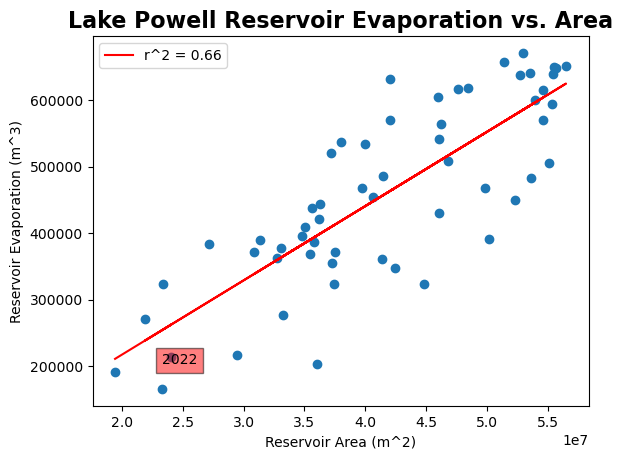

In [5]:
# plot a scatter plot with res_et_df against res_area_df for the lake_powell column
plt.scatter(x=res_area_df['lake_powell'], y=res_et_df[res_et_df.index.isin(res_area_df.index)] ['lake_powell'])
plt.ylabel('Reservoir Evaporation (m^3)')
plt.xlabel('Reservoir Area (m^2)')
# plot a trend line for this scatter plot with the label being the r^2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(res_area_df['lake_powell'], res_et_df[res_et_df.index.isin(res_area_df.index)]['lake_powell'])
plt.plot(res_area_df['lake_powell'], intercept + slope*res_area_df['lake_powell'], 'r', label='r^2 = ' + str(round(r_value**2, 2)))
plt.legend()
# add a text box pointing out where the index 2022 is and format with an arrow pointing to the point
plt.text(res_area_df['lake_powell'][2022], res_et_df[res_et_df.index.isin(res_area_df.index)]['lake_powell'][2022], '2022', bbox=dict(facecolor='red', alpha=0.5))
# add a title with size 16 font and bold
plt.title('Lake Powell Reservoir Evaporation vs. Area', fontsize=16, fontweight='bold')

In [6]:
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')

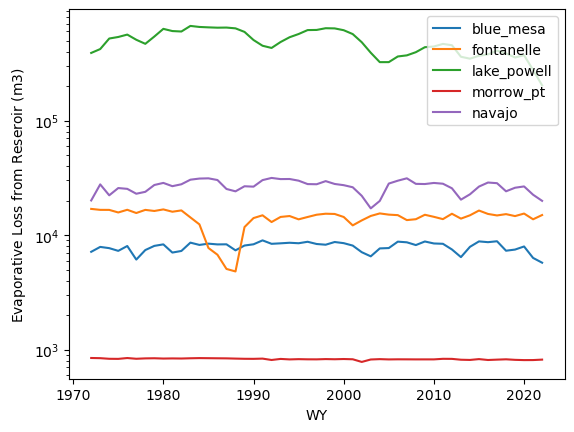

In [7]:
res_et_df.sort_index().loc[1972:].plot()

plt.ylabel('Evaporative Loss from Reseroir (m$3$)')
plt.yscale('log')

In [8]:
(res_et_df.sum(axis=1))#/ ucrb_boundary.to_crs('32613').area.values * 1000

WY
1967    215610.783968
1968    250824.380192
1969    317445.526874
1970    369861.089380
1971    427690.985125
1972    434719.356396
1973    474384.269755
1974    568074.897790
1975    586735.253334
1976    614425.337516
1977    553321.148171
1978    516723.529494
1979    594342.647060
1980    686814.633112
1981    655660.433727
1982    651936.459450
1983    725003.834278
1984    709696.280795
1985    700024.874779
1986    693587.878618
1987    688569.300443
1988    676003.649211
1989    642229.758350
1990    555075.589564
1991    505247.901887
1992    484564.310612
1993    539960.957893
1994    589374.155059
1995    622987.702371
1996    668839.522577
1997    670838.077995
1998    694628.653038
1999    691059.529935
2000    666420.636388
2001    616652.821088
2002    526768.552011
2003    430386.094721
2004    367664.739187
2005    375797.271894
2006    417385.186397
2007    425467.815123
2008    446448.214236
2009    489903.322636
2010    495813.438035
2011    518370.100972
2012   

In [9]:
lees_ferry_flow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)

In [10]:
((res_et_df.sum(axis=1)).loc[2000:2022].mean()*1.5)/lees_ferry_flow.loc[2000:2022].mean()

1    0.054773
dtype: float64

### Are basin snowpack trends significantly different from the mean over the period of record?

In [11]:
filepath = '../data/snowdata/UCRB_basin_swe'
filelist = os.listdir(filepath)


In [12]:
basin_sm50_list = []
for i,file in enumerate(filelist):
    basin_name = filelist[i].split('-swe.csv')[0]
    tmp_df = pd.read_csv(os.path.join(filepath,file))
    df = tmp_df.drop(columns=['date','Median Peak SWE'])
    # Identify SM50 - when 50% of the snowpack has melted
    peak_swe_date = [df[col].idxmax() for col in df.columns]
    sm_50 = [df[col].max()/2 for col in df.columns]
    sm_50_date = [abs(df[col].loc[peak_swe_date[i]:] - sm_50[i]).idxmin() for i, col in enumerate(df.columns)]
    sm_50_date_series = pd.Series(sm_50_date,index=df.columns)
    sm_50_date_series.name = basin_name
    basin_sm50_list.append(sm_50_date_series)

In [13]:
basin_snowmelt_list = []
for i,file in enumerate(filelist):
    basin_name = filelist[i].split('-swe.csv')[0]
    tmp_df = pd.read_csv(os.path.join(filepath,file))
    df = tmp_df.drop(columns=['date','Median Peak SWE'])
    # Identify SM50 - when 50% of the snowpack has melted
    sm_date = [df[col].rolling(7).mean().dropna()[100:].idxmin() for col in df.columns]
    basin_sm_date_series = pd.Series(sm_date,index=df.columns)
    basin_sm_date_series.name = basin_name
    basin_snowmelt_list.append(basin_sm_date_series)

/tmp/ipykernel_17197/1923972372.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sm_date = [df[col].rolling(7).mean().dropna()[100:].idxmin() for col in df.columns]
/tmp/ipykernel_17197/1923972372.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sm_date = [df[col].rolling(7).mean().dropna()[100:].idxmin() for col in df.columns]
/tmp/ipykernel_17197/1923972372.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, t

In [14]:
basin_peakswe_date_list = []
for i,file in enumerate(filelist):
    basin_name = filelist[i].split('-swe.csv')[0]
    tmp_df = pd.read_csv(os.path.join(filepath,file))
    df = tmp_df.drop(columns=['date','Median Peak SWE'])
    # Identify SM50 - when 50% of the snowpack has melted
    peak_swe_date = [df[col].idxmax() for col in df.columns]
    peak_swe_date_series  = pd.Series(peak_swe_date,index=df.columns)
    peak_swe_date_series.name = basin_name
    basin_peakswe_date_list.append(peak_swe_date_series)

In [15]:
basin_peakswe_list = []
for i,file in enumerate(filelist):
    basin_name = filelist[i].split('-swe.csv')[0]
    tmp_df = pd.read_csv(os.path.join(filepath,file))
    df = tmp_df.drop(columns=['date','Median Peak SWE'])
    # Identify SM50 - when 50% of the snowpack has melted
    peak_swe = [df[col].max() for col in df.columns]
    peak_swe_series  = pd.Series(peak_swe,index=df.columns)
    peak_swe_series.name = basin_name
    basin_peakswe_list.append(peak_swe_series)

In [19]:
drop_col_list = ['Min', 'Max', '10%', '30%', '70%','90%', "Median ('91-'20)", "Median (POR)"]
sm_50_date_df = pd.concat(basin_sm50_list,axis=1).drop(drop_col_list)
sm_50_date_df.index = sm_50_date_df.index.astype(int)
sm_50_date_df = sm_50_date_df.sort_index()

sm_df = pd.concat(basin_snowmelt_list,axis=1).drop(drop_col_list)
sm_df.index = sm_df.index.astype(int)
sm_df = sm_df.sort_index()

peak_swe_date_df = pd.concat(basin_peakswe_date_list,axis=1).drop(drop_col_list)
peak_swe_date_df.index = peak_swe_date_df.index.astype(int)
peak_swe_date_df = peak_swe_date_df.sort_index()

peak_swe_df = pd.concat(basin_peakswe_list,axis=1).drop(drop_col_list)
peak_swe_df.index = peak_swe_df.index.astype(int)
peak_swe_df = peak_swe_df.sort_index()
peak_swe_df = peak_swe_df*25.4


In [20]:
# make a function out of the above block of code
def linregress_ci(x,y,alpha=0.05):
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y,)
    # Create points for the regression line
    x = np.linspace(x.min(), x.max(), x.size) # x coordinates from min and max values 
    y = slope * x + intercept # y coordinates using the slope and intercept from our linear regression
    # compute SST for col
    sst_x = np.sum( (x - np.mean(x))**2 )
    # Compute the standard error
    sigma = stderr * np.sqrt(sst_x)
    r_squared = rvalue**2
    # conf interval calculations
    sB1 = sigma/np.sqrt(sst_x)
    # t-value for alpha/2 with n-2 degrees of freedom
    dof = x.size - 2
    t = stats.t.ppf(1-alpha/2, dof)
    # compute upper and lower b1 limits
    B1_upper = slope + t * sB1
    B1_lower = slope - t * sB1
    # compute corresponding b0s
    B0_upper = y.mean() - B1_upper*x.mean()
    B0_lower = y.mean() - B1_lower*x.mean()
    return B1_upper, B1_lower, B0_upper, B0_lower, x, y, r_squared

Text(-0.02, 0.5, 'Peak SWE (mm)')

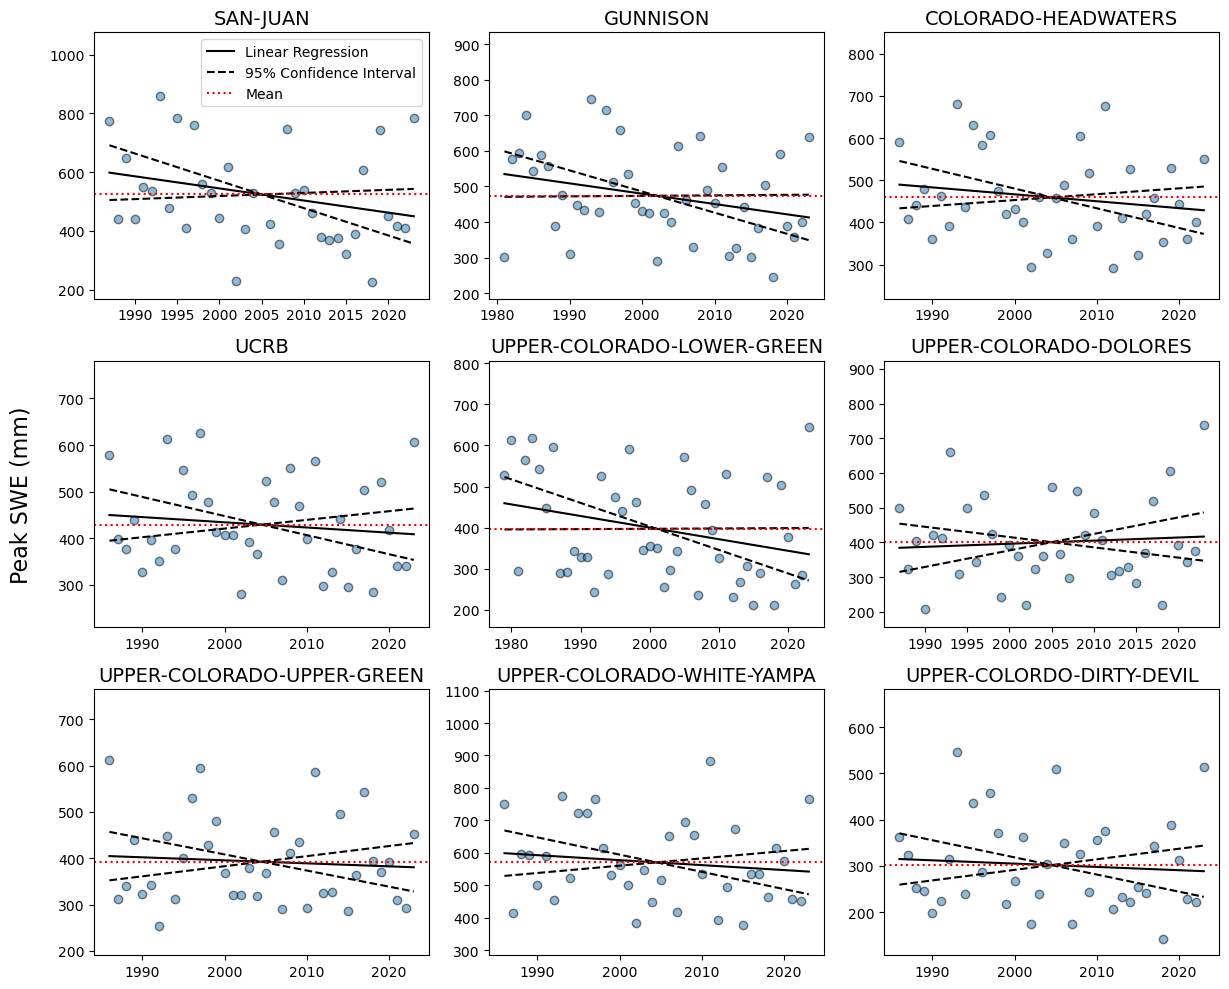

In [24]:
# iterate through the columns in peak_swe_df and plot the linear regression using subplots
fig, axs = plt.subplots(3,3, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i, col in enumerate(peak_swe_df.columns):
    B1_upper, B1_lower, B0_upper, B0_lower, x, y, r_squared = linregress_ci(peak_swe_df[col].dropna().index, peak_swe_df[col].dropna().values, alpha=0.05)
    axs[i].scatter(peak_swe_df[col].dropna().index, peak_swe_df[col].dropna().values, ec='k', alpha=0.5)
    axs[i].plot(x, y, color='k', label='Linear Regression')
    axs[i].plot(x, B1_upper*x + B0_upper, color='k', linestyle='--', label='95% Confidence Interval')
    axs[i].plot(x, B1_lower*x + B0_lower, color='k', linestyle='--')
    axs[i].axhline(peak_swe_df[col].dropna().mean(), color='red', linestyle=':', label='Mean')
    axs[i].set_title(col.upper(),size=14)
    
    # set the ylimit as 25% more than the max and 25% less than the min values
    axs[i].set_ylim(peak_swe_df[col].dropna().min()*0.75, peak_swe_df[col].dropna().max()*1.25)
# create a shared y axis label that says 'Peak SWE (mm)'
axs[0].legend()
fig.text(-0.02, 0.5, 'Peak SWE (mm)', va='center', rotation='vertical', fontsize=16)


Text(-0.02, 0.5, 'Date of SM50')

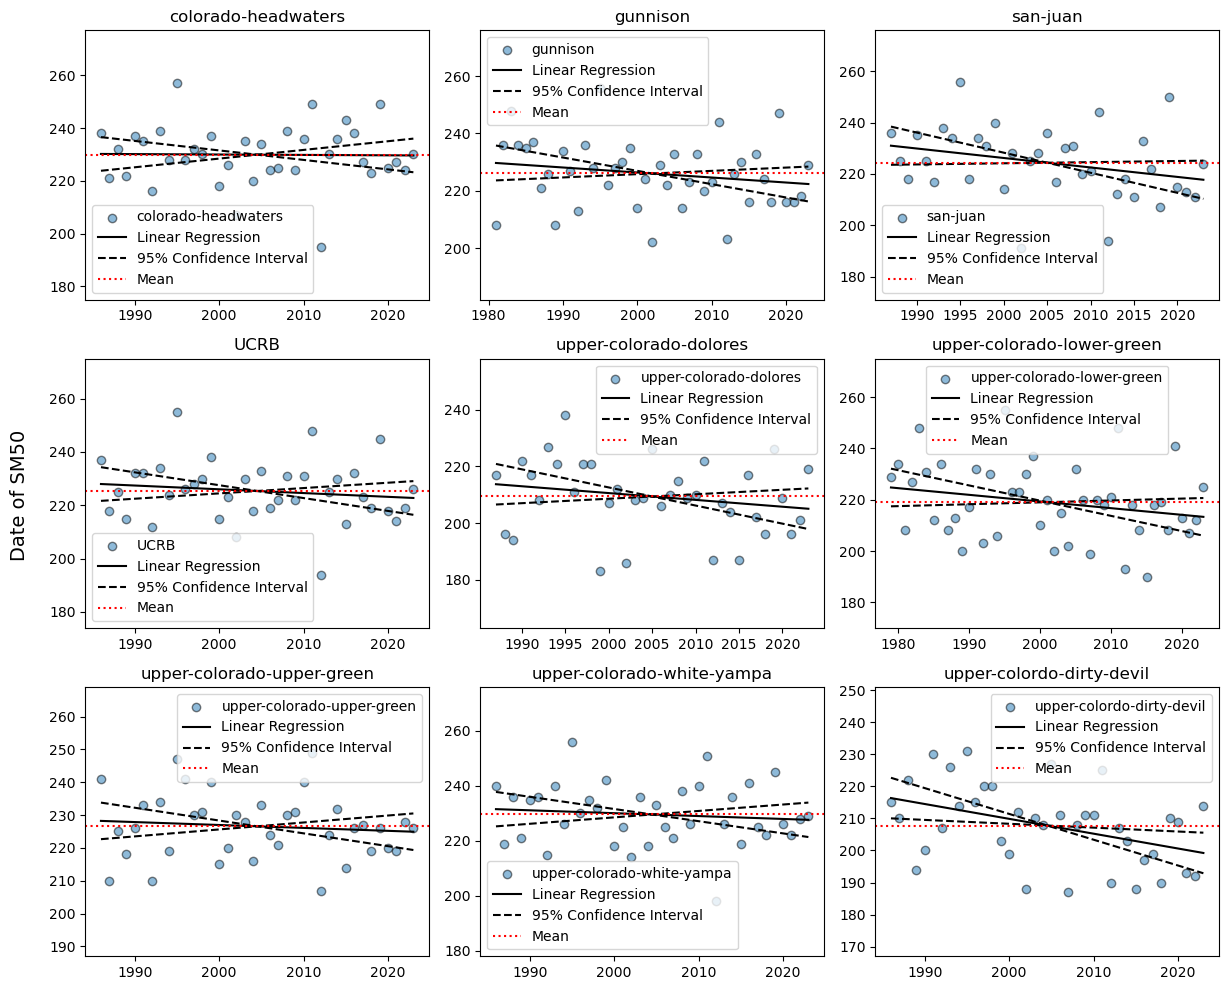

In [130]:
# iterate through the columns in sm_50_date_df and plot the linear regression using subplots
fig, axs = plt.subplots(3,3, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i, col in enumerate(sm_50_date_df.columns):
    B1_upper, B1_lower, B0_upper, B0_lower, x, y, r_squared = linregress_ci(sm_50_date_df[col].dropna().index, sm_50_date_df[col].dropna().values, alpha=0.05)
    axs[i].scatter(sm_50_date_df[col].dropna().index, sm_50_date_df[col].dropna().values, label=col, ec='k', alpha=0.5)
    axs[i].plot(x, y, color='k', label='Linear Regression')
    axs[i].plot(x, B1_upper*x + B0_upper, color='k', linestyle='--', label='95% Confidence Interval')
    axs[i].plot(x, B1_lower*x + B0_lower, color='k', linestyle='--')
    axs[i].axhline(sm_50_date_df[col].dropna().mean(), color='red', linestyle=':', label='Mean')
    axs[i].set_title(col)
    axs[i].legend()
    # set the ylimit as 25% more than the max and 25% less than the min values
    axs[i].set_ylim(sm_50_date_df[col].dropna().min()-20, sm_50_date_df[col].dropna().max()+20)
# create a shared y axis label that says 'Date of Peak SWE'
fig.text(-0.02, 0.5, 'Date of SM50', va='center', rotation='vertical', fontsize=14)

Text(-0.02, 0.5, 'Date of Peak SWE')

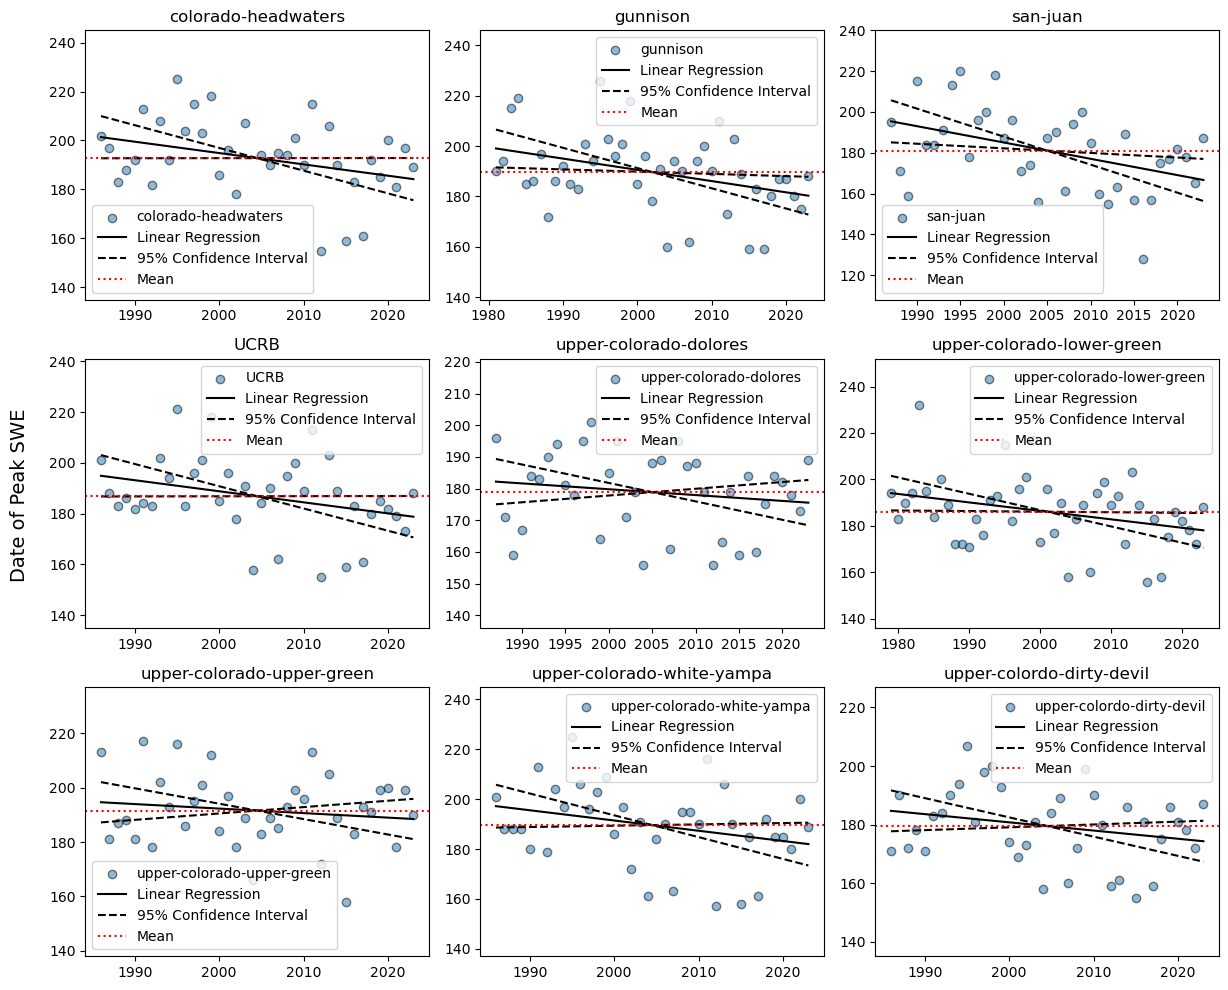

In [128]:
# iterate through the columns in peak_swe_date_df and plot the linear regression using subplots
fig, axs = plt.subplots(3,3, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i, col in enumerate(peak_swe_date_df.columns):
    B1_upper, B1_lower, B0_upper, B0_lower, x, y, r_squared = linregress_ci(peak_swe_date_df[col].dropna().index, peak_swe_date_df[col].dropna().values, alpha=0.05)
    axs[i].scatter(peak_swe_date_df[col].dropna().index, peak_swe_date_df[col].dropna().values, label=col, ec='k', alpha=0.5)
    axs[i].plot(x, y, color='k', label='Linear Regression')
    axs[i].plot(x, B1_upper*x + B0_upper, color='k', linestyle='--', label='95% Confidence Interval')
    axs[i].plot(x, B1_lower*x + B0_lower, color='k', linestyle='--')
    axs[i].axhline(peak_swe_date_df[col].dropna().mean(), color='red', linestyle=':', label='Mean')
    axs[i].set_title(col)
    axs[i].legend()
    # set the ylimit as 25% more than the max and 25% less than the min values
    axs[i].set_ylim(peak_swe_date_df[col].dropna().min()-20, peak_swe_date_df[col].dropna().max()+20)
    
# create a shared y axis label that says 'Date of Peak SWE'
fig.text(-0.02, 0.5, 'Date of Peak SWE', va='center', rotation='vertical', fontsize=14)

Text(-0.02, 0.5, 'Date of Snow Melt')

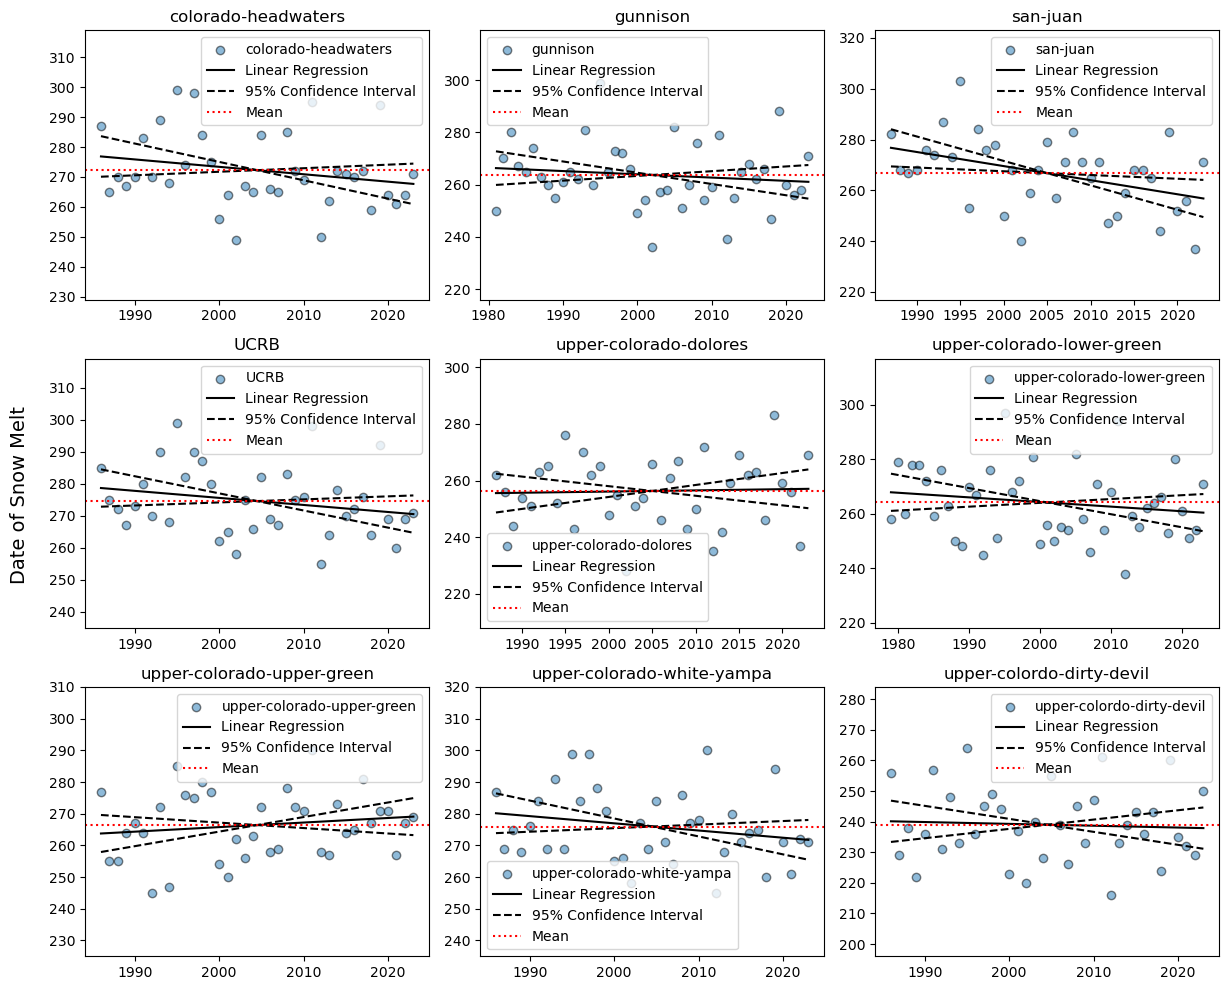

In [129]:
# iterate through the columns in sm_df and plot the linear regression using subplots
fig, axs = plt.subplots(3,3, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i, col in enumerate(sm_df.columns):
    B1_upper, B1_lower, B0_upper, B0_lower, x, y, r_squared = linregress_ci(sm_df[col].dropna().index, sm_df[col].dropna().values, alpha=0.05)
    axs[i].scatter(sm_df[col].dropna().index, sm_df[col].dropna().values, label=col, ec='k', alpha=0.5)
    axs[i].plot(x, y, color='k', label='Linear Regression')
    axs[i].plot(x, B1_upper*x + B0_upper, color='k', linestyle='--', label='95% Confidence Interval')
    axs[i].plot(x, B1_lower*x + B0_lower, color='k', linestyle='--')
    axs[i].axhline(sm_df[col].dropna().mean(), color='red', linestyle=':', label='Mean')
    axs[i].set_title(col)
    axs[i].legend()
    # set the ylimit as 25% more than the max and 25% less than the min values
    axs[i].set_ylim(sm_df[col].dropna().min()-20, sm_df[col].dropna().max()+20)
# create a shared y axis label that says 'Date of Peak SWE'
fig.text(-0.02, 0.5, 'Date of Snow Melt', va='center', rotation='vertical', fontsize=14)